In [1]:
%load_ext autoreload
%autoreload 2

from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer, AerSimulator
from qiskit.providers.fake_provider import GenericBackendV2
from matplotlib import pyplot as plt
import sys
import numpy as np
from qiskit.quantum_info import Pauli
from qiskit_aer.noise import NoiseModel, pauli_error

sys.path.append("../../pauli_lindblad_per/")
from tomography.experiment import SparsePauliTomographyExperiment as tomography

plt.style.use("ggplot")

In [7]:
inst_map = [0,1]
n = 2
qc = QuantumCircuit(n)
qc.cx(0,1)
print(qc.draw())

coupling_list = [(0, 1), (1, 0)]

errorops = [Pauli("XY")]
errorprobs = [0.1]

# Erzeuge PauliError und NoiseModel
twoqubit_error = pauli_error([(op, p) for op, p in zip(errorops, errorprobs)] + [(Pauli("II"), 1 - sum(errorprobs))])
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(twoqubit_error, ['cx'])

backend = GenericBackendV2(num_qubits=n, coupling_map=coupling_list)

          
q_0: ──■──
     ┌─┴─┐
q_1: ┤ X ├
     └───┘


In [8]:
experiment = tomography(
    circuits = [qc], #list of circuits from which to get the layers requiring tomography
    inst_map = inst_map, #which physical qubits on the processor to map the qubits in the circuit
    backend = backend #quantum backend
    )

experiment.generate(
    samples = 100, #Number of samples to take from the fidelity pair measurements
    single_samples = 250, #samples to take from the pair-breaking measurements
    depths = [2,4,16,32,64] #values of 2n to make the pair measurements. Numbers must be even and non-zero
    )

shots = 1024
def executor(circuits):
    return backend.run(circuits, shots = shots, noise_model=noise_model).result().get_counts()

#run the experiment
experiment.run(executor)

noisedataframe = experiment.analyze()
print("noise coefficients:", list(noisedataframe.noisemodels.values())[0].coeffs)
print("spam coefficients:", list(zip(noisedataframe.spam.keys(), noisedataframe.spam.values())))

noise coefficients: [(IX, np.float64(0.0)), (XY, np.float64(0.11134224543895528)), (ZZ, np.float64(0.0)), (YY, np.float64(0.0)), (XZ, np.float64(0.0)), (ZX, np.float64(0.0)), (IY, np.float64(0.0)), (XX, np.float64(0.0)), (ZI, np.float64(0.00012943745665227192)), (ZY, np.float64(0.0)), (IZ, np.float64(0.0)), (YI, np.float64(0.0)), (XI, np.float64(0.0)), (YX, np.float64(0.0)), (YZ, np.float64(7.735540913038222e-05))]
spam coefficients: [(IX, np.float64(0.9999999775753267)), (IY, np.float64(0.9999788589320225)), (ZI, np.float64(0.9999996464855916)), (IZ, np.float64(0.999999999986396)), (YI, np.float64(0.9983434472194596)), (XI, np.float64(0.9999788589320225))]


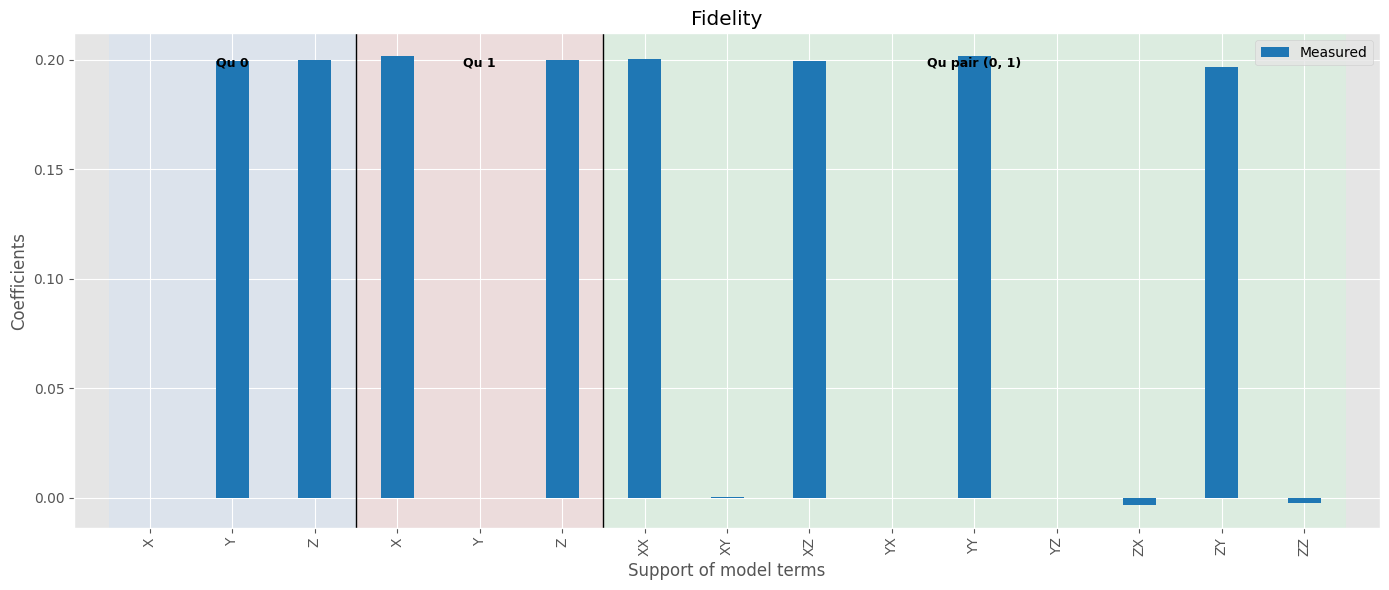

In [9]:
layer = experiment.analysis.get_layer_data(0)
layer.plot_infidelitites(plot_style = 2)

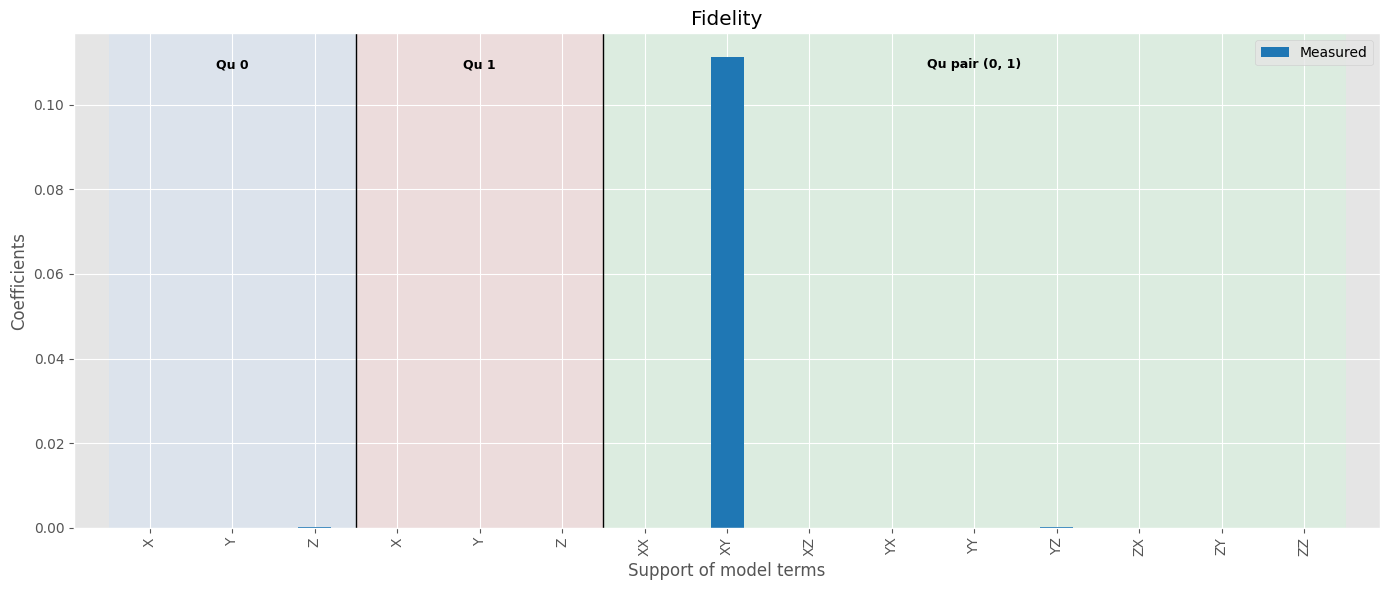

In [10]:
layer.plot_coeffs(plot_style = 2)